# INTRODUCCIÓN A FloPy - Ejercicio 2

Modelo en planta de 2 capas, asignando condiciones de carga constate en las fronteras.

# Instalar paquetes

In [ ]:
pip install flopy

## Cargar paquetes

In [2]:
import os
#os.chdir(os.path.join(os.path.dirname(__file__)))
print(os.getcwd())
import flopy
#import plot_basic as pltb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Equipo\FloPy_1


# Configuración del modelo
Aquí se indican las rutas donde se encuentran los ejecutables, los archivos base y dónde se generarán los resultados de las simulaciones.

In [3]:
# Assigns the name and creates the object model MODFLOW
modelname = 'Ejercicio_planta'
exe_name="Exe/MODFLOW-NWT_64.exe"
model_ws='Results'
#mf1 = flopy.modflow.Modflow(modelname, exe_name="Exe/mf2005.exe", model_ws=model_ws)
mf1 = flopy.modflow.Modflow(modelname, exe_name=exe_name,model_ws=model_ws)


# Configuración de la geometría del modelo

In [4]:
Lx = 1000.
Ly = 1000.
# vector quecontiene la cota de fondo de las dos capas
zbot = [-50.,-100.]
Nlay = 2
nrow = 10
ncol = 10
ztop = np.ones((nrow, ncol), dtype=np.int32)

#Ciclo para asignar la cota del terreno
for i in range(ncol):
    ztop[:,i]=10-i
    
delr = Lx / ncol
delc = Ly / nrow


## Discretización del modelo

In [5]:
# https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html
dis = flopy.modflow.ModflowDis(mf1,Nlay,nrow,ncol,delr=delr,delc=delc,top=ztop,botm=zbot,itmuni=4,lenuni=2)      

[<AxesSubplot:title={'center':' model_top'}>,
 <AxesSubplot:title={'center':'botm layer 1'}>,
 <AxesSubplot:title={'center':'botm layer 2'}>]

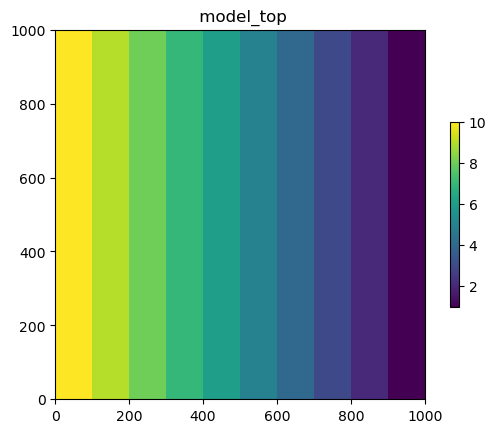

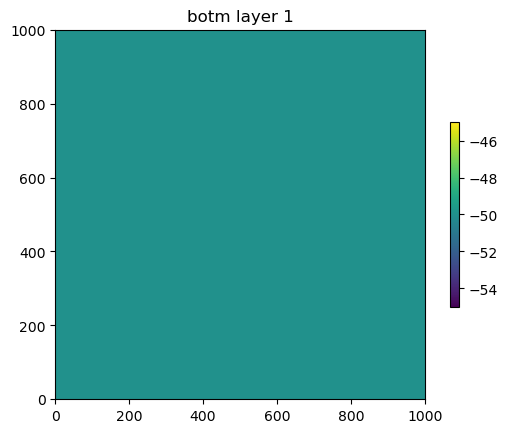

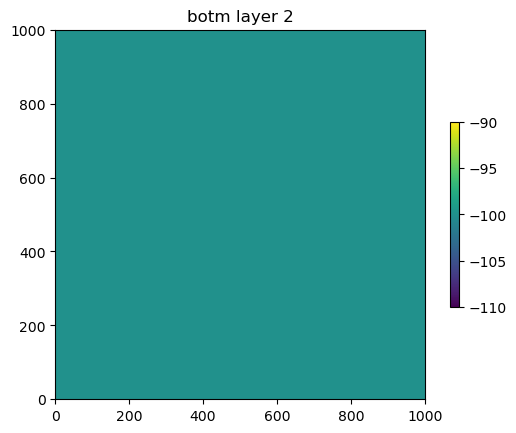

In [6]:
dis.plot()

## Condiciones de frontera

In [15]:
## Variable to package BAS
#ibound
ibound = np.ones((Nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
#Initial level
strt = np.ones((Nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 10.
strt[:, :, -1] = 0.
bas = flopy.modflow.ModflowBas(mf1, ibound=ibound, strt=strt)

C:\Users\Equipo\AppData\Roaming\Python\Python39\site-packages\flopy\mbase.py:652: UserWarning: Unit 13 of package BAS6 already in use.
  warn(
C:\Users\Equipo\AppData\Roaming\Python\Python39\site-packages\flopy\mbase.py:661: UserWarning: Two packages of the same type, Replacing existing 'BAS6' package.
  warn(


[<AxesSubplot:title={'center':'ibound layer 1'}>,
 <AxesSubplot:title={'center':'ibound layer 2'}>,
 <AxesSubplot:title={'center':'strt layer 1'}>,
 <AxesSubplot:title={'center':'strt layer 2'}>]

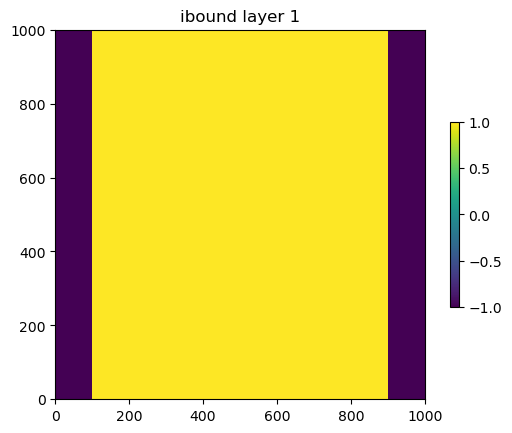

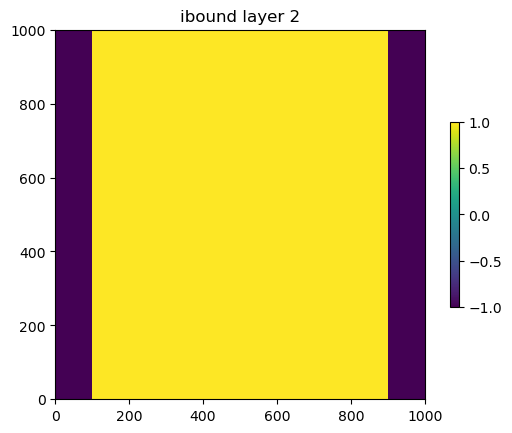

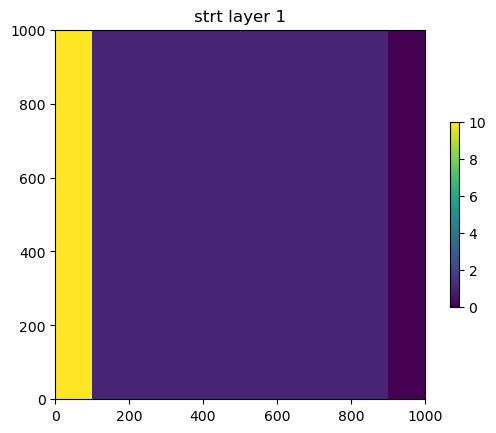

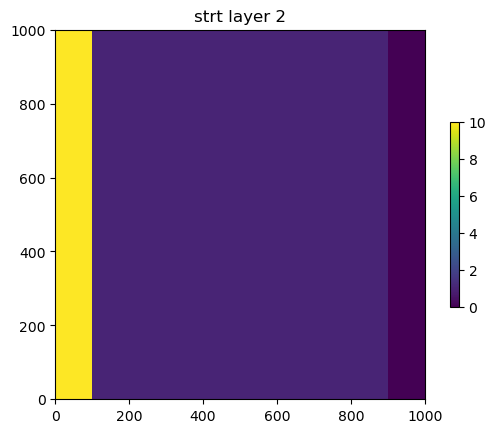

In [13]:
bas.plot()

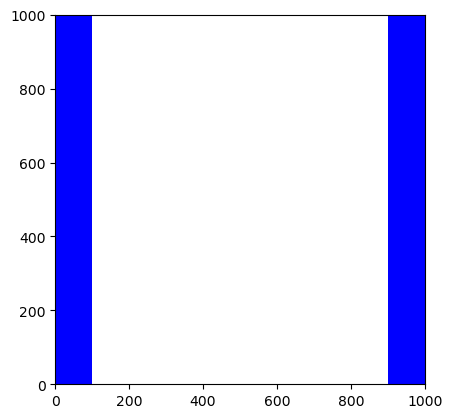

In [17]:
mapview = flopy.plot.PlotMapView(model=mf1)
quadmesh = mapview.plot_ibound()

In [16]:
mf1.bas6.check()



BAS6 PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    isolated cells in ibound array
    Not a number



## Asignar propiedades a los layers

In [19]:
#https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html
lpf = flopy.modflow.ModflowLpf(mf1, hk=10., vka=10., ipakcb=53)


C:\Users\Equipo\AppData\Roaming\Python\Python39\site-packages\flopy\mbase.py:652: UserWarning: Unit 15 of package LPF already in use.
  warn(
C:\Users\Equipo\AppData\Roaming\Python\Python39\site-packages\flopy\mbase.py:661: UserWarning: Two packages of the same type, Replacing existing 'LPF' package.
  warn(


In [21]:
#https://flopy.readthedocs.io/en/3.4.3/source/flopy.modflow.mfpcg.html
pcg = flopy.modflow.mfpcg.ModflowPcg(mf1, mxiter=100, iter1=60, hclose=1e-03, rclose=1e-03, relax=1.0) 
#The tuple "(0,0)" indicates that those changes will be applied for stress period 0 and time step 0
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget','save drawdown']}
oc = flopy.modflow.ModflowOc(mf1, stress_period_data=spd, compact=False)
mf1.write_input()
# mf1.check(level = 2)
success, buff = mf1.run_model()

FloPy is using the following executable to run the model: ..\Exe\MODFLOW-NWT_64.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: Ejercicio_planta.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/31 14:35:57

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2023/10/31 14:35:57
 Elapsed run time:  0.017 Seconds

  Normal termination of simulation


In [22]:
#%%Save and print Bugdet
from flopy.utils import MfListBudget

ml_list = MfListBudget('Results/'+modelname+'.list')
budget= ml_list.get_dataframes()
print(budget[0].T/86400) # day

                       1970-01-02
STORAGE_IN           0.000000e+00
CONSTANT_HEAD_IN     1.355854e-01
TOTAL_IN             1.355854e-01
STORAGE_OUT          0.000000e+00
CONSTANT_HEAD_OUT    1.355854e-01
TOTAL_OUT            1.355854e-01
IN-OUT               1.130278e-08
PERCENT_DISCREPANCY  0.000000e+00


# Cargas hidráulicas

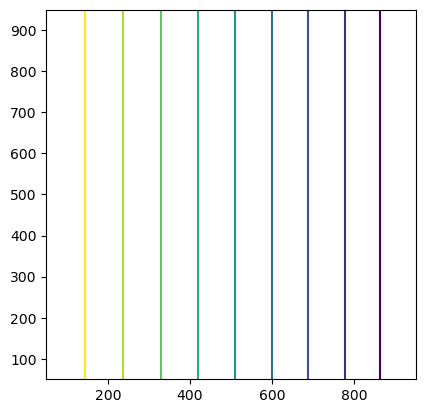

In [24]:
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
plt.subplot(1, 1, 1, aspect='equal')
hds = bf.HeadFile(model_ws+'/'+modelname + '.hds')
head = hds.get_data(totim=1.0)
levels = np.arange(1, 10, 1)
extent = (delr / 2., Lx - delr / 2., Ly - delc / 2., delc / 2.)
plt.contour(head[0, :, :], levels=levels, extent=extent)
#Guardar figuras
#plt.savefig(model_ws+'/'+'sesion1_a.png')

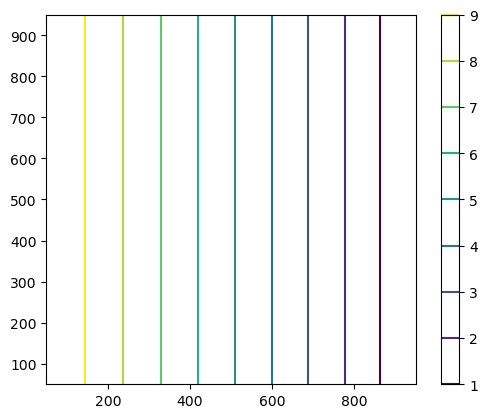

In [25]:
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
plt.subplot(1, 1, 1, aspect='equal')
hds = bf.HeadFile(model_ws+'/'+modelname + '.hds')
head = hds.get_data(totim=1.0)
levels = np.arange(1, 10, 1)
extent = (delr / 2., Lx - delr / 2., Ly - delc / 2., delc / 2.)
plt.contour(head[0, :, :], levels=levels, extent=extent)
plt.colorbar()
#plt.savefig(model_ws+'/'+'Ex02_E1.png')

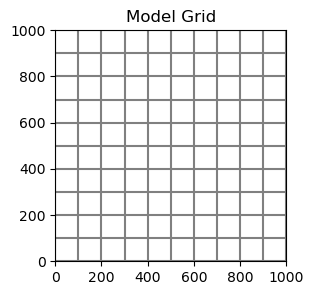

In [29]:
#Visualización malla
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=mf1)
linecollection = mapview.plot_grid()
t = ax.set_title("Model Grid")

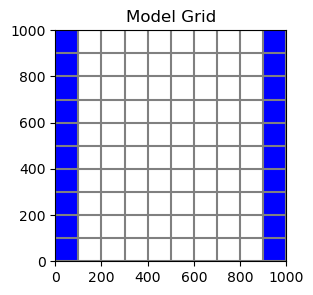

In [32]:
#Agregar las condiciones de frontera
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=mf1)
linecollection = mapview.plot_grid()
mapview.plot_ibound()
t = ax.set_title("Model Grid")

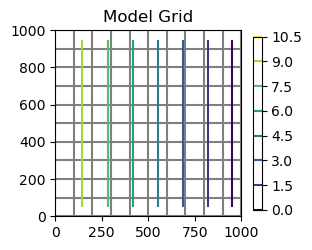

In [43]:
#Agregar isopiezas de la primera capa
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=mf1)
linecollection = mapview.plot_grid()
contour_set = mapview.contour_array(head[0, :, :])
t = ax.set_title("Model Grid")
plt.colorbar(contour_set, shrink=0.75)

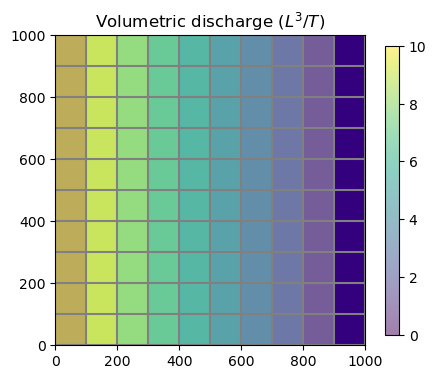

In [41]:
import os
fname = os.path.join(model_ws, modelname+'.cbc')
cbb = flopy.utils.CellBudgetFile(fname)
frf = cbb.get_data(text='FLOW RIGHT FACE')[0]
fff = cbb.get_data(text='FLOW FRONT FACE')[0]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.set_title('Volumetric discharge (' + r'$L^3/T$' + ')')
mapview = flopy.plot.PlotMapView(model=mf1)
quadmesh = mapview.plot_ibound()
quadmesh = mapview.plot_array(head[0, :, :], alpha=0.5)
#quiver = mapview.plot_discharge(frf, fff)
linecollection = mapview.plot_grid()
plt.colorbar(quadmesh, shrink=0.75)

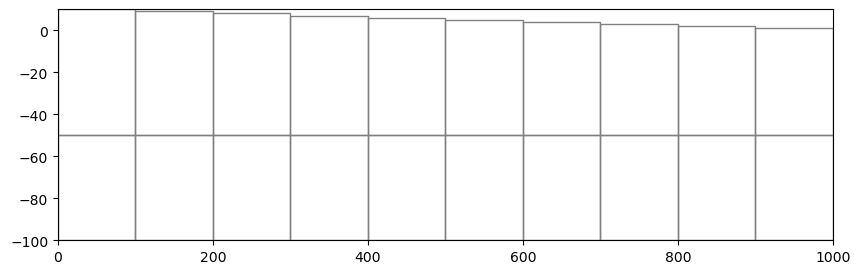

In [49]:
fig = plt.figure(figsize=(10, 3))
xsect = flopy.plot.PlotCrossSection(model=mf1, line={'Row': 3})
linecollection = xsect.plot_grid()
t = ax.set_title('Row 3 Cross-Section - Model Grid')

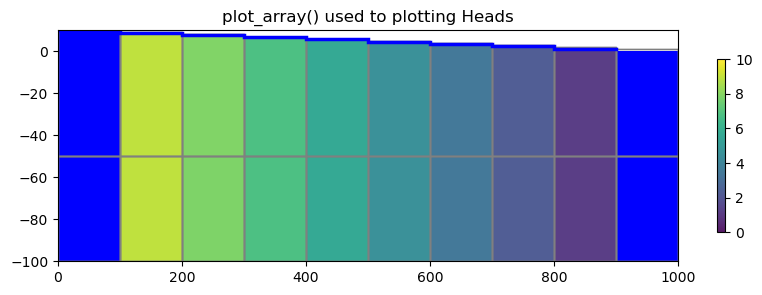

In [53]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('plot_array() used to plotting Heads')
xsect = flopy.plot.PlotCrossSection(model=mf1, line={'Row': 3})
pc = xsect.plot_array(head, masked_values=[999.], head=head, alpha=0.9)
patches = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()
#plot the surface and model grid
wt = xsect.plot_surface(head[0], masked_values=[999.], color='blue', lw=2.5)
linecollection = xsect.plot_grid()
cb = plt.colorbar(pc, shrink=0.75)